In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d, make_smoothing_spline

from astropy import units as u

mpl.rc('font', family='serif', size=16)

In [2]:
import jax
import equinox as eqx
from tinygp.helpers import JAXArray

jax.config.update("jax_enable_x64", True)

In [3]:
def dateformat(ax):
    locator   = mpl.dates.AutoDateLocator()
    formatter = mpl.dates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

In [4]:
def histogram_residuals(mu_ss, mu_gp, var_ss, var_gp):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3), sharey=True)
    ax1.hist(mu_ss-mu_gp)
    ax2.hist(var_ss-var_gp)
    ax1.set(xlabel=r'$\mu_{ss} - \mu_{gp}$', )
    ax2.set(xlabel=r'$\sigma^2_{ss} - \sigma^2_{gp}$');
    fig.tight_layout()
    return fig, (ax1, ax2)

In [5]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import expm, solve

key = jax.random.PRNGKey(0)

## Import `onefit` to get full GP version of SHO 

In [6]:
import sys
sys.path.insert(0, '/Users/rrubenzahl/Research/Solar/onefit/onefit/')

In [7]:
import importlib
import gpkernels
importlib.reload(gpkernels)
from gpkernels import *

# Kernel definition in `tinygp` and `ssmolgp`

In [8]:
import tinygp
import smolgp

In [9]:
## SHO Kernel
S=2.36
w=0.0195
Q=7.63
sigma = jnp.sqrt(S*w*Q)

qsKernel = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)
ssKernel = smolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)
gpKernel = gpkernels.OscillationKernel()

Defaulting to solar values.


In [10]:
## Matern-5/2 Kernel
scale = 600. # sec
sigma = 1.

qsKernel = tinygp.kernels.quasisep.Matern52(scale=scale, sigma=sigma)
ssKernel = smolgp.kernels.Matern52(scale=scale, sigma=sigma)
gpKernel = gpkernels.Matern52Kernel()

In [11]:
%%timeit -n 100
qsKernel = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)

15 μs ± 715 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%%timeit -n 100
ssKernel =smolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)

17.4 μs ± 849 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Use tinygp to define a 'ground truth' process

In [13]:
# true_kernel = qsKernel

kernel1 = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)
kernel2 = tinygp.kernels.quasisep.Matern52(scale=600., sigma=1.)
true_kernel = kernel1 + kernel2

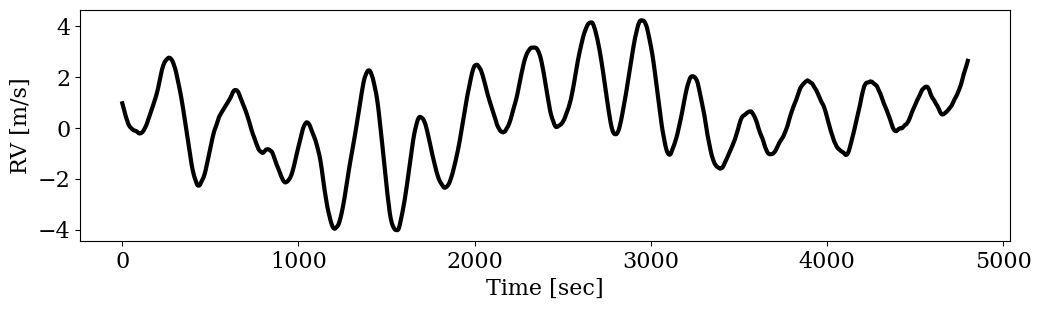

In [14]:
def get_true_gp(tmin, tmax, tunit='s', dt=1):
    t = u.Quantity(jnp.arange(tmin, tmax, dt), tunit).to('s').value
    true_gp = tinygp.GaussianProcess(true_kernel, t)
    # gp.sample adds small random noise for numerical stability
    y_sample = true_gp.sample(key=jax.random.PRNGKey(32)) 
    f = make_smoothing_spline(t, y_sample, lam=10/60)
    return t, f

baseline_minutes = 80
t, f = get_true_gp(0, baseline_minutes, 'min', dt=1/60)
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(t, f(t), label='Example SHO', color='k', lw=3)
ax.set(ylabel='RV [m/s]', xlabel=f'Time [sec]');

## Make synthetic observations

In [15]:
#### Simulated dataset
def generate_data(N, yerr=0.3, tmin=None, tmax=None, baseline_minutes=80):

    # Generate true GP over baseline
    t, f = get_true_gp(0, baseline_minutes, 'min', dt=1/60)
    tmin = t.min() if tmin is None else tmin
    tmax = t.max() if tmax is None else tmax

    # Generate synthetic observations (no exposure time)
    t_train = jnp.linspace(tmin, tmax, N+2)[1:-1]
    y_true = f(t_train)
    y_train = y_true + yerr * jax.random.normal(key, shape=(N,))
    return t_train, y_train

In [16]:
np.random.seed(231)

N = 30
yerr = 0.3 # m/s
t_train, y_train = generate_data(N, yerr)

i,di=10,5
delete = jnp.arange(i,i+di,1)
t_train = jnp.delete(t_train, delete)
y_train = jnp.delete(y_train, delete)

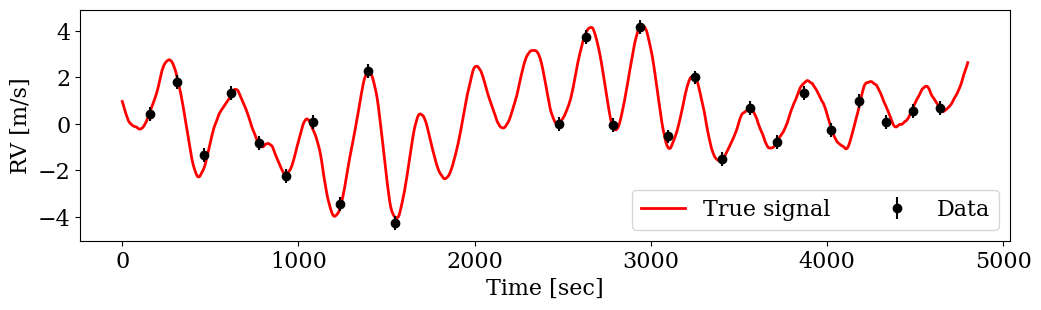

In [17]:
fig, ax = plt.subplots(1,1,figsize=(12,3))

ax.plot(t, f(t), label='True signal', color='r', lw=2)
ax.errorbar(t_train, y_train, yerr, fmt='o', color='k', label='Data')

ax.legend(ncol=2)
ax.set(ylabel='RV [m/s]', xlabel=f'Time [sec]');

In [18]:
def sample_data(N, yerr=0.3):
    return generate_data(N, qsKernel, yerr=yerr)

In [19]:
t_test = jnp.linspace(t.min(), t.max(), 1000)

# Multi-component model

1. build with tinygp, build with smolgp

2. show they give the same likelihood

3. show they give the same conditioned/predictive mean/var

4. test mixture of integrated and regular kernel

## 1a. Build with `ssmolgp`

In [20]:
## SHO
ssm1 = smolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)
# ssm2 = smolgp.kernels.SHO(omega=0.00234587265, 
#                            quality=1/jnp.sqrt(2), 
#                            sigma=0.329)
ssm2 = smolgp.kernels.Matern52(scale=600., sigma=1.)
ssm = ssm1 + ssm2
# ssm = ssm1 * ssm2
ssm

Sum(
  dimension=5,
  kernel1=SHO(omega=0.0195, quality=7.63, sigma=1.0, eta=weak_f64[]),
  kernel2=Matern52(scale=600.0, sigma=1.0)
)

## 1b. Build with `tinygp`

In [21]:
kernel1 = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)
# kernel2 = tinygp.kernels.quasisep.SHO(omega=0.00234587265, 
#                                       quality=1/jnp.sqrt(2), 
#                                       sigma=0.329)
kernel2 = tinygp.kernels.quasisep.Matern52(scale=600., sigma=1.)

kernel = kernel1 + kernel2
# # kernel = kernel1 * kernel2
kernel

Sum(
  kernel1=SHO(omega=0.0195, quality=7.63, sigma=1.0),
  kernel2=Matern52(scale=600.0, sigma=1.0)
)

In [22]:
gp_ss = smolgp.GaussianProcess(kernel=ssm, X=t_train, diag=yerr**2)
gp_qs = tinygp.GaussianProcess(kernel=kernel, X=t_train, diag=yerr**2)

## 2. Likelihoods verification

In [23]:
gp_qs.log_probability(y_train)

Array(-42.86318234, dtype=float64)

In [24]:
gp_ss.log_probability(y_train)

Array(-42.86318234, dtype=float64)

In [25]:
gp_qs.log_probability(y_train) - gp_ss.log_probability(y_train)

Array(1.42108547e-14, dtype=float64)

## 3a. Condition verification

In [26]:
## Throws an error if X_test is not given (TODO: open issue in tinygp)
condGP_qs = gp_qs.condition(y_train, t_train).gp
llh, condGP_ss = gp_ss.condition(y_train)

# ## also going to have to do a check w/ to_dense in SSM predict
# condGP2.predict(t_test, return_var=True)

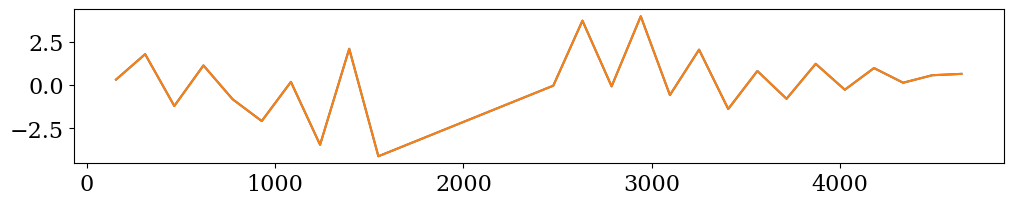

In [27]:
plt.figure(figsize=(12,2))
plt.plot(t_train, condGP_qs.loc)
plt.plot(t_train, condGP_ss.loc)

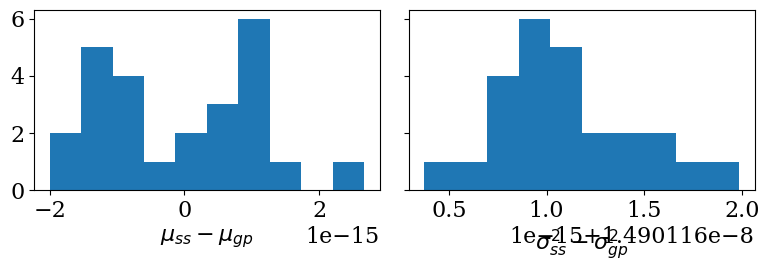

In [28]:
fig, (ax1, ax2) = histogram_residuals(condGP_qs.loc, condGP_ss.loc,
                                      condGP_qs.variance, condGP_ss.variance)

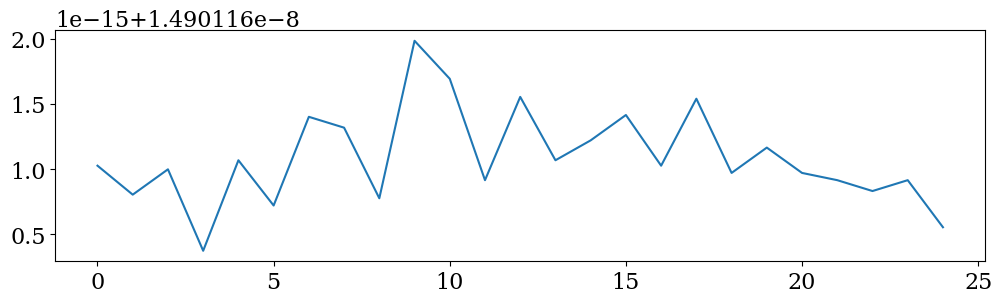

In [29]:
plt.figure(figsize=(12,3))
plt.plot(condGP_qs.variance-condGP_ss.variance)

In [30]:
# gp_qs.predict(y_train) # throws an error if X_test is not given

# The problem is with this line, 
# something to do with `a` which comes from p, q, a = self.lower
# gp_qs.solver.factor.inv()

## 3b. Prediction verification

In [31]:
mu_qs, var_qs = gp_qs.predict(y_train, t_test, return_var=True)

In [32]:
mu_ss, var_ss = condGP_ss.predict(t_test, return_var=True)
# mu_ss, var_ss = gp_ss.predict(t_test, y_train, return_var=True)

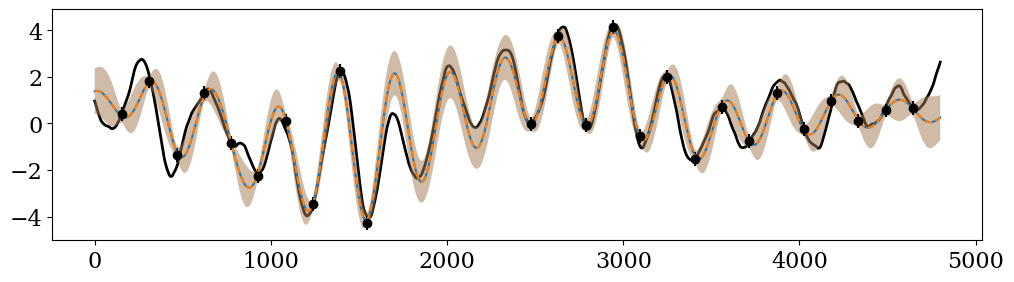

In [33]:
plt.figure(figsize=(12,3))

plt.plot(t, f(t), label='True signal', color='k', lw=2, zorder=-10)
plt.errorbar(t_train, y_train, yerr, fmt='o', color='k', label='Data', alpha=1)

plt.plot(t_test, mu_qs)
plt.fill_between(t_test, mu_qs-jnp.sqrt(var_qs), mu_qs+jnp.sqrt(var_qs), alpha=0.3)

plt.plot(t_test, mu_ss, ls='--')
plt.fill_between(t_test, mu_ss-jnp.sqrt(var_ss), mu_ss+jnp.sqrt(var_ss), alpha=0.3)

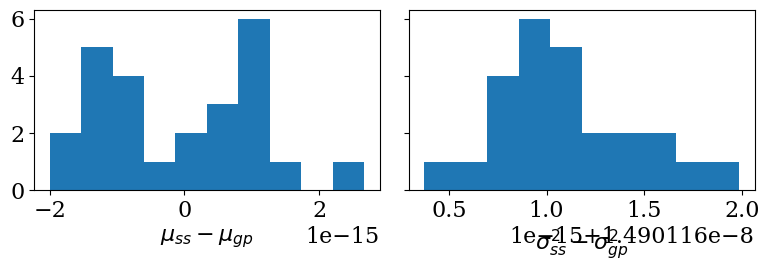

In [34]:
fig, (ax1, ax2) = histogram_residuals(condGP_qs.loc, condGP_ss.loc,
                                      condGP_qs.variance, condGP_ss.variance)

## Predict at a single component kernel

In [35]:
from smolgp.kernels import Sum, Product
def extract_leaf_kernels(kernel):
    """Recursively extract all leaf kernels from a sum or product of kernels"""
    if isinstance(kernel, (Sum, Product)):
        return extract_leaf_kernels(kernel.kernel1) + extract_leaf_kernels(kernel.kernel2)
    else:
        return [kernel]

In [36]:
extract_leaf_kernels(condGP_ss.kernel)

[SHO(omega=0.0195, quality=7.63, sigma=1.0, eta=weak_f64[]),
 Matern52(scale=600.0, sigma=1.0)]

In [37]:
condGP_ss.kernel.dimension

5

In [38]:
condGP_ss.kernel.observation_model(0)

Array([[1, 0, 1, 0, 0]], dtype=int64)

In [39]:
H_comp1 = jnp.array([[1,0,0,0,0]])
H_comp2 = jnp.array([[0,0,1,0,0]])

mean1 = jax.vmap(lambda m: H_comp1 @ m)(condGP_ss.states.smoothed_mean).squeeze()
mean2 = jax.vmap(lambda m: H_comp2 @ m)(condGP_ss.states.smoothed_mean).squeeze()

In [40]:
m_test, P_test = condGP_ss.predict(t_test, 
                                   return_full_state=True, 
                                   return_var=True)

In [41]:
def project(m_test, P_test, H):

    def proj(m, P):
        mu = H @ m
        var = H @ P @ H.T
        return mu.squeeze(), var.squeeze()
    
    return jax.vmap(proj)(m_test, P_test)

In [42]:
mu1, var1 = project(m_test, P_test, H_comp1)
mu2, var2 = project(m_test, P_test, H_comp2)

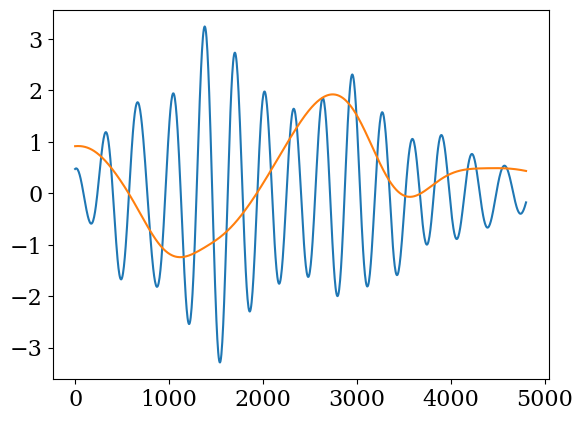

In [43]:
# plt.plot(t_train, mean1)
# plt.plot(t_train, mean2)
plt.plot(t_test, mu1)
plt.plot(t_test, mu2)

In [44]:
y_ss = condGP_ss.loc
y_gp = condGP_qs.loc
yerr_ss = jnp.sqrt(condGP_ss.variance)
yerr_gp = jnp.sqrt(condGP_qs.variance)

mu_gp = mu_qs
std_gp = jnp.sqrt(var_qs)
std_ss = jnp.sqrt(var_ss)

### Plot

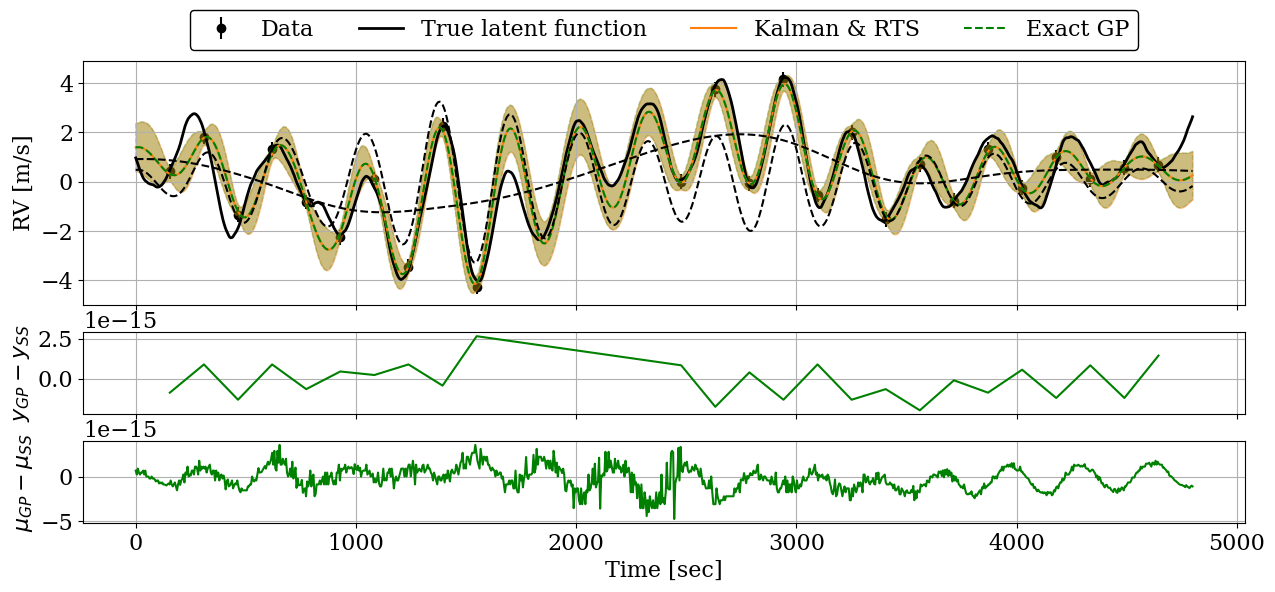

In [45]:
fig, (ax, rax1, rax2) = plt.subplots(3,1, figsize=(15, 6), sharex=True, gridspec_kw={'height_ratios':[3,1,1]})

cobs = 'k' # 'w'
ctrue = 'k'
cgp  = 'g'
ckal = 'C0'
crts = 'C1'

## Data and true signal
l1 = ax.errorbar(t_train, y_train, yerr, fmt='o', zorder=0, color=cobs, label="Data")
l2, = ax.plot(t, f(t), color=ctrue, lw=2, label="True latent function")

## Test predictions
l4, = ax.plot(t_test, mu_ss, color=crts,  ls='-', label="Kalman & RTS")
ax.fill_between(t_test, mu_ss-std_ss, mu_ss+std_ss, ls='-', color=crts, alpha=0.4)

l5, = ax.plot(t_test, mu_gp,  color=cgp,   ls='--',  label="Exact GP")
ax.fill_between(t_test, mu_gp-std_gp, mu_gp+std_gp, ls='--', color=cgp, alpha=0.2)

## Component signals
ax.plot(t_test, mu1, color='k', ls='--')
ax.plot(t_test, mu2, color='k', ls='--')

lines = [l1, l2, l4, l5]
ax.legend(lines, [l.get_label() for l in lines],
            ncol=4,# loc='upper center', #fontsize=14,
            loc='lower center', bbox_to_anchor=[0.5,1],
              framealpha=1, edgecolor='k', 
            # facecolor='#232323' 
            )
# ax.set_title("State-Space GP vs. Exact GP")
ax.set(ylabel='RV [m/s]', )#xlim=[max(t_test.min(), t.min().to(kernel.tunit).value),
                        #  min(t_test.max(), t.max().to(kernel.tunit).value)])
# ax.set_ylim(f(t).min()-.2, f(t).max()+1)
ax.grid()

# rax.plot(t_train, y_kal-y_true, ckal, ls=':')
rax1.plot(t_train, y_gp-y_ss,  cgp , ls='-')
# rax1.plot(t_train, )

mu_true = f(t_test/60)
rax2.plot(t_test, mu_gp-mu_ss, c=cgp , ls='-')
# rax2.fill_between(t_test, (mu_ss-std_ss) - (mu_gp-std_gp), 
#                           (mu_ss+std_ss) - (mu_gp+std_gp), 
#                   ls='--', color='k', alpha=0.2)

rax1.set(ylabel=r'$y_{GP}-y_{SS}$')
rax2.set(xlabel='Time [sec]', ylabel=r'$\mu_{GP}-\mu_{SS}$')

rax1.grid();rax2.grid();

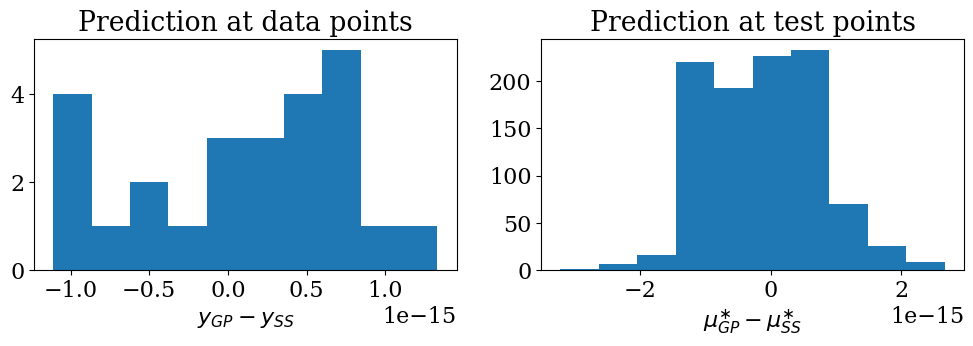

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 3))
ax1.hist(y_gp - y_ss);
# ax1.hist(yvar_gp - yvar_ss);
ax1.set(title='Prediction at data points', xlabel='$y_{GP} - y_{SS}$')

ax2.hist(mu_gp - mu_ss);
# ax2.hist(var_gp - var_ss);
ax2.set(title='Prediction at test points', xlabel=r'$\mu^{\ast}_{GP} - \mu^{\ast}_{SS}$');

# Integrated version tests

In [40]:
from smolgp.helpers import Phibar_from_VanLoan

## Augmented matrices

In [41]:
isho = smolgp.kernels.integrated.IntegratedSHO(omega=w, quality=Q, sigma=sigma, num_insts=1)

F_aug = isho.design_matrix()
L_aug = isho.noise_effect_matrix()
A_aug = lambda dt: isho.transition_matrix(0, dt)
Q_aug = lambda dt: isho.process_noise(0, dt)
Reset_matrix = isho.reset_matrix

print(isho.dimension, ':', L_aug.shape, F_aug.shape, A_aug(3).shape, Q_aug(3).shape, Reset_matrix(0).shape)

4 : (4, 1) (4, 4) (4, 4) (4, 4) (4, 4)


## Test the analytic and numerical integrated transition matrix are the same

In [42]:
# "Default" instantation of integrated SHO
sho = smolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)
idef = smolgp.kernels.integrated.IntegratedStateSpaceModel(base_model=sho, num_insts=1)
vanloan  = lambda dt: idef.integrated_transition_matrix(0, dt)

# Analytic version from above
analytic = lambda dt: isho.integrated_transition_matrix(0, dt)

## Compare
dts = jnp.linspace(0, 100, 1000)
jnp.all(jax.vmap(lambda dt: jnp.allclose(analytic(dt), vanloan(dt)))(dts))

Array(True, dtype=bool)

## Integrated GP from `smolgp` vs. `tinygp` using Luhn et al. method

### New simulated dataset for testing the integrated verison

In [43]:
def generate_timeseries(tmin, tmax, texp_mean=178, texp_std=20, readout=40):
    ts = []
    texps = []
    tend_prev = tmin - readout
    while tend_prev < tmax:
        texp = np.random.normal(loc=texp_mean, scale=texp_std)
        t_start = tend_prev + readout
        t = t_start + texp/2
        tend_prev = t_start + texp
        ts.append(t)
        texps.append(texp)
    return jnp.array(ts), jnp.array(texps)

def make_exposure(tmid, texp):
    t_in_exp = jnp.linspace(tmid-texp/2, tmid+texp/2, 100)
    return jnp.mean(f(t_in_exp))

In [ ]:
Ninst = 2

# tmin = t.min()
# tmax = t.max()
tmin = 0.0
tmax = 3600.0
print(tmin, tmax)

## Remake true GP
t, f = get_true_gp(tmin-300, tmax+300, 's', dt=1)
print(len(t))

0.0 3600.0
4200


In [105]:
#### Simulated dataset
np.random.seed(231)
if Ninst==1:
    yerr = 0.3 # m/s
    texp = 180. # sec
    readout = 0 # 40 # sec
    cadence = texp + readout
    t_train = jnp.arange(tmin+texp, tmax-texp, cadence)
    N = len(t_train)
    texp_train = jnp.full(N, texp)  # constant exposure time for all observations
    yerr_train = jnp.full(N, yerr)  # constant uncertainty for all observations
    instids = jnp.zeros(N, dtype=int)
elif Ninst==2:
    ### TWO INSTRUMENTS
    texp1=55.; yerr1=0.3; rout1=28.
    texp2=180; yerr2=0.3; rout2=40.
    cadence1 = texp1 + rout1; cadence2 = texp2 + rout2
    times1 = jnp.arange(tmin+texp1, tmax-texp1, cadence1)  # uniformly sample N points
    times2 = jnp.arange(tmin+texp2, tmax-texp2, cadence2)  # uniformly sample N points

    ## EXPRES-like variable texp
    times2, texp2_train = generate_timeseries(tmin, tmax, texp_mean=180, texp_std=30, readout=rout2)

    ## Random subsample and generate y_train
    N1 = len(times1); N2 = len(times2);
    N1 = int(0.6*N1); N2 = int(0.8*N2)
    times1 = np.random.choice(times1, N1, replace=False)
    texp1_train = jnp.full_like(times1, texp1)
    # times2 = np.random.choice(times2, N2, replace=False)
    # texp2_train = jnp.full_like(times2, texp2)

    t_train = jnp.hstack([times1, times2])
    instids = jnp.hstack([jnp.zeros(N1, dtype=int), jnp.ones(N2, dtype=int)]) # which instrument recorded each obs
    texp_train = jnp.hstack([texp1_train, texp2_train]) # exposure time for each obs
    yerr_train = jnp.hstack([jnp.full(N1, yerr1), jnp.full(N2, yerr2)]) # uncertainty for each obs
    sortidx = jnp.argsort(t_train)
    t_train    = t_train[sortidx]
    instids    = instids[sortidx]
    texp_train = texp_train[sortidx]
    yerr_train = yerr_train[sortidx]
else:
    raise NotImplementedError("Only Ninst=1 or 2 simulated datasets implemented")

###### Generate synthetic measurements
y_inst = f(t_train)
y_true = jnp.array([make_exposure(t_train[n], texp_train[n]) for n in range(len(t_train))])
y_train = y_true + yerr * jax.random.normal(key, shape=(len(t_train),))
N = len(t_train)
R = jnp.square(yerr_train)

In [106]:
## True process
t_true = jnp.linspace(t.min(), t.max(), 1000)
y_true = f(t_true)

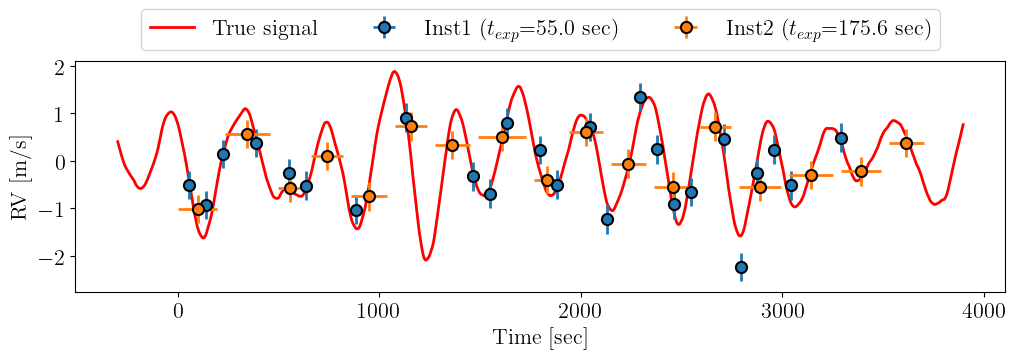

In [107]:
fig, ax = plt.subplots(1,1,figsize=(12,3))

ax.plot(t_true, y_true, label='True signal', color='r', lw=2)
# ax.errorbar(tobs.value, y_inst,  yerr=yerr, fmt='o', color='grey')
# ax.errorbar(tobs.value, y_train, xerr=texp/60/2, yerr=yerr, fmt='o', color='k', label=r'$t_{exp}$=' + f'{texp} sec')
for instid in range(Ninst):
    inst = (instids==instid)
    ax.errorbar(t_train[inst], y_train[inst], xerr=texp_train[inst]/2, yerr=yerr,
                 fmt='o', label=f'Inst{instid+1} ($t_{{exp}}$={np.median(texp_train[inst]):.1f} sec)')

ax.legend(ncol=3, bbox_to_anchor=[0.5,1], loc='lower center')
ax.set(ylabel='RV [m/s]', xlabel=f'Time [sec]');

In [108]:
tmid = t_train # exposure midpoints

## Construct interleaved time array for integrated Kalman/RTS
ts = tmid - texp_train/2  # Exposure start times
te = tmid + texp_train/2  # Exposure end times
obsid = jnp.arange(len(tmid)).repeat(2)  # which observation does each time belong to

# Interleave start and end times into one array (fastest)
# https://stackoverflow.com/questions/5347065/interleaving-two-numpy-arrays-efficiently
t_states = jnp.empty((ts.size + te.size,), dtype=tmid.dtype)
t_states = t_states.at[0::2].set(ts)  # evens are start times
t_states = t_states.at[1::2].set(te)  # odds are end times
# Have to re-sort because exposures can overlap
sortidx  = jnp.argsort(t_states)
t_states = t_states[sortidx]
obsid    = obsid[sortidx] 
stateids = jnp.tile(jnp.array([0,1]), len(tmid))[sortidx] # 0 for t_s, 1 for t_e

In [109]:
print('k   t[s]    obs  inst  state')
print('----------------------------')
for k in range(len(t_states)):
    print(f'{k:<2d}  {t_states[k]:<7.1f}  {obsid[k]:<2}   {instids[obsid[k]]}   {stateids[k]}')
    if k>8:
        break

k   t[s]    obs  inst  state
----------------------------
0   0.0      1    1   0
1   27.5     0    0   0
2   82.5     0    0   1
3   110.5    2    0   0
4   165.5    2    0   1
5   192.5    1    1   1
6   193.5    3    0   0
7   232.5    4    1   0
8   248.5    3    0   1
9   359.5    5    0   0


## Run integrated solver

In [110]:
isho_ss = smolgp.kernels.integrated.IntegratedSHO(omega=w, quality=Q, sigma=sigma, num_insts=Ninst)
isho_gp = gpkernels.IntegratedOscillationKernel()

Defaulting to solar values.


In [111]:
igp_ss = smolgp.GaussianProcess(kernel=isho_ss, 
          X=(t_train, texp_train, instids), diag=R)

In [112]:
igp_gp = tinygp.GaussianProcess(kernel=isho_gp, 
          X=(t_train, instids, texp_train), diag=R)

In [113]:
# a,b,c,d, v,S = igp_ss.solver.Kalman(y_train, return_v_S=True)

## Likelihood

In [114]:
llh_ss = igp_ss.log_probability(y_train)
llh_gp = igp_gp.log_probability(y_train)

llh_ss - llh_gp

Array(0., dtype=float64)

## Condition

In [115]:
llh, condGP_gp = igp_gp.condition(y_train, X_test=(t_train, instids, texp_train))
llh

Array(-31.63396083, dtype=float64)

In [116]:
llh, condGP_ss = igp_ss.condition(y_train)
llh

Array(-31.63396083, dtype=float64)

In [117]:
(condGP_gp.mean-condGP_ss.mean)

Array([-2.65498734e-12,  1.83575377e-12,  6.83020307e-12,  8.43977666e-13,
       -4.48308057e-12, -7.31414929e-13,  2.72698530e-12, -3.40749651e-12,
       -5.71293568e-11,  6.23933682e-11,  6.56197319e-12, -9.99200722e-16,
        1.45439216e-14, -5.66213743e-15,  4.72399897e-14,  4.35762537e-15,
       -1.61093361e-13,  5.56776847e-14,  9.39248679e-14,  3.94129174e-15,
       -4.32986980e-15, -8.65973959e-15, -4.44089210e-15, -4.55191440e-15,
        4.44089210e-15, -4.59875193e-15, -1.06581410e-14, -8.88178420e-16,
        6.66133815e-16,  1.11022302e-15,  2.05391260e-15, -6.77236045e-15,
       -8.88178420e-15,  4.44089210e-15, -1.16573418e-15, -1.66533454e-15,
       -8.77076189e-15, -1.11022302e-15,  2.60902411e-15, -1.88737914e-15,
       -2.60902411e-15,  4.44089210e-16], dtype=float64)

In [118]:
(condGP_gp.variance - condGP_ss.variance)

Array([1.49175377e-08, 1.49090025e-08, 1.50096955e-08, 1.49028153e-08,
       1.49478147e-08, 1.49024100e-08, 1.49184817e-08, 1.49280630e-08,
       2.24839251e-08, 2.39392945e-08, 1.35215986e-08, 1.49011729e-08,
       1.49011836e-08, 1.49011737e-08, 1.49013882e-08, 1.49011653e-08,
       1.49041840e-08, 1.49016422e-08, 1.49024930e-08, 1.49011626e-08,
       1.49011618e-08, 1.49011620e-08, 1.49011620e-08, 1.49011632e-08,
       1.49011610e-08, 1.49011608e-08, 1.49011615e-08, 1.49011611e-08,
       1.49011614e-08, 1.49011620e-08, 1.49011606e-08, 1.49011637e-08,
       1.49011533e-08, 1.49012336e-08, 1.49011669e-08, 1.49011974e-08,
       1.49015969e-08, 1.49011635e-08, 1.49011642e-08, 1.49011631e-08,
       1.49011626e-08, 1.49011614e-08], dtype=float64)

In [119]:
## Unpack conditioned states
m_predicted_int = condGP_ss.states.predicted_mean
m_filtered_int  = condGP_ss.states.filtered_mean
m_smoothed_int  = condGP_ss.states.smoothed_mean
P_predicted_int = condGP_ss.states.predicted_var
P_filtered_int  = condGP_ss.states.filtered_var
P_smoothed_int  = condGP_ss.states.smoothed_var
print(m_predicted_int.shape, m_filtered_int.shape, m_smoothed_int.shape)
print(P_predicted_int.shape,P_filtered_int.shape, P_smoothed_int.shape)

(84, 6) (84, 6) (84, 6)
(84, 6, 6) (84, 6, 6) (84, 6, 6)


In [120]:
# which = stateids>=0 # stateids==1
# # plt.plot(t_states[which], m_predicted_int[:,0][which], 'o-')
# # plt.plot(t_states[which], m_filtered_int[:,0][which], 'o-')
# # plt.plot(t_states[which], m_smoothed_int[:,0][which], 'o-')

# starts = stateids==0
# ends   = stateids==1
# plt.plot(t_states[starts], m_filtered_int[:,0][starts], 'o-')
# plt.plot(t_states[ends],  m_filtered_int[:,0][ends]+.1, 'o-')

# # plt.plot(t_states[starts], m_smoothed_int[:,0][starts], 'o')
# # plt.plot(t_states[ends],  m_smoothed_int[:,0][ends]+.1, 'o')

In [121]:
y_gp = condGP_gp.loc
yvar_gp = condGP_gp.variance
yerr_gp = jnp.sqrt(yvar_gp)

y_ss = condGP_ss.loc
yvar_ss = condGP_ss.variance
yerr_ss = jnp.sqrt(yvar_ss)

## Predict

In [122]:
## Test array
# t_test = jnp.linspace(tmin-2000, tmax+2000, 1000)
t_test = jnp.linspace(tmin-300, tmax+300, 1000)

In [123]:
######## test times      0-exposure            instid=0
X_test = (t_test, jnp.zeros_like(t_test), jnp.zeros_like(t_test).astype(int))

In [124]:
## Full GP predict
mu_gp, var_gp = igp_gp.predict(y_train, X_test, return_var=True)
std_gp  = jnp.sqrt(var_gp)

In [125]:
## SSM predict
mu_ss, var_ss = condGP_ss.predict(X_test, return_var=True)
std_ss = jnp.sqrt(var_ss)

In [126]:
# t_states, conditioned_states, _ = condGP_ss.states()
# (m_predicted, P_predicted), \
# (m_filtered, P_filtered), \
# (m_smoothed, P_smoothed) = conditioned_states
# t_states

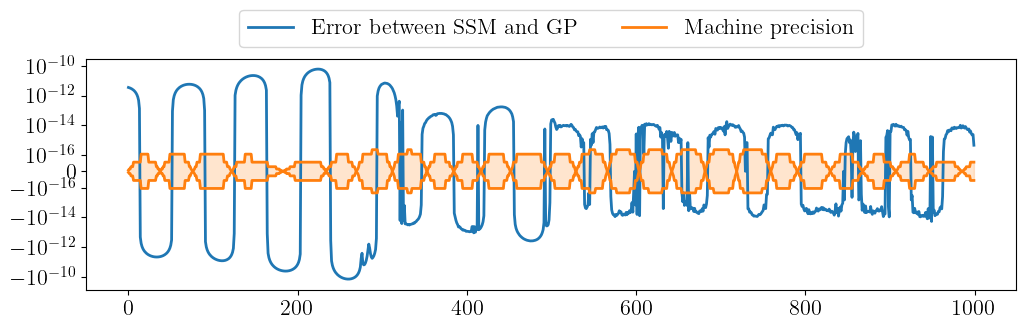

In [127]:
plt.figure(figsize=(12,3))
plt.plot((mu_ss-mu_gp), label='Error between SSM and GP')

eps = np.spacing(mu_gp)
plt.plot(eps, label='Machine precision')
plt.plot(-eps, color='C1')
plt.fill_between(np.arange(len(eps)), -eps, eps, color='C1', alpha=0.2)

plt.legend(loc='lower center', bbox_to_anchor=[0.5,1], ncol=2)
plt.yscale('symlog', linthresh=1e-16) 

In [128]:
np.spacing(3)

np.float64(4.440892098500626e-16)

## Comparison plot

In [129]:
in_exposure = jnp.zeros_like(t_test, dtype=bool)
for t1, t2 in zip(t_states[0::2], t_states[1::2]):
    in_exposure = in_exposure | ((t_test >= t1) & (t_test <= t2))

tstart, tend = (t_train - texp_train/2), (t_train + texp_train/2)

In [130]:
mpl.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
mpl.rc("text", usetex=True)
mpl.rcParams["axes.formatter.useoffset"] = False

plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markeredgewidth'] = 1.5
plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.markeredgecolor'] = 'k'
plt.rcParams['lines.linewidth'] = 2

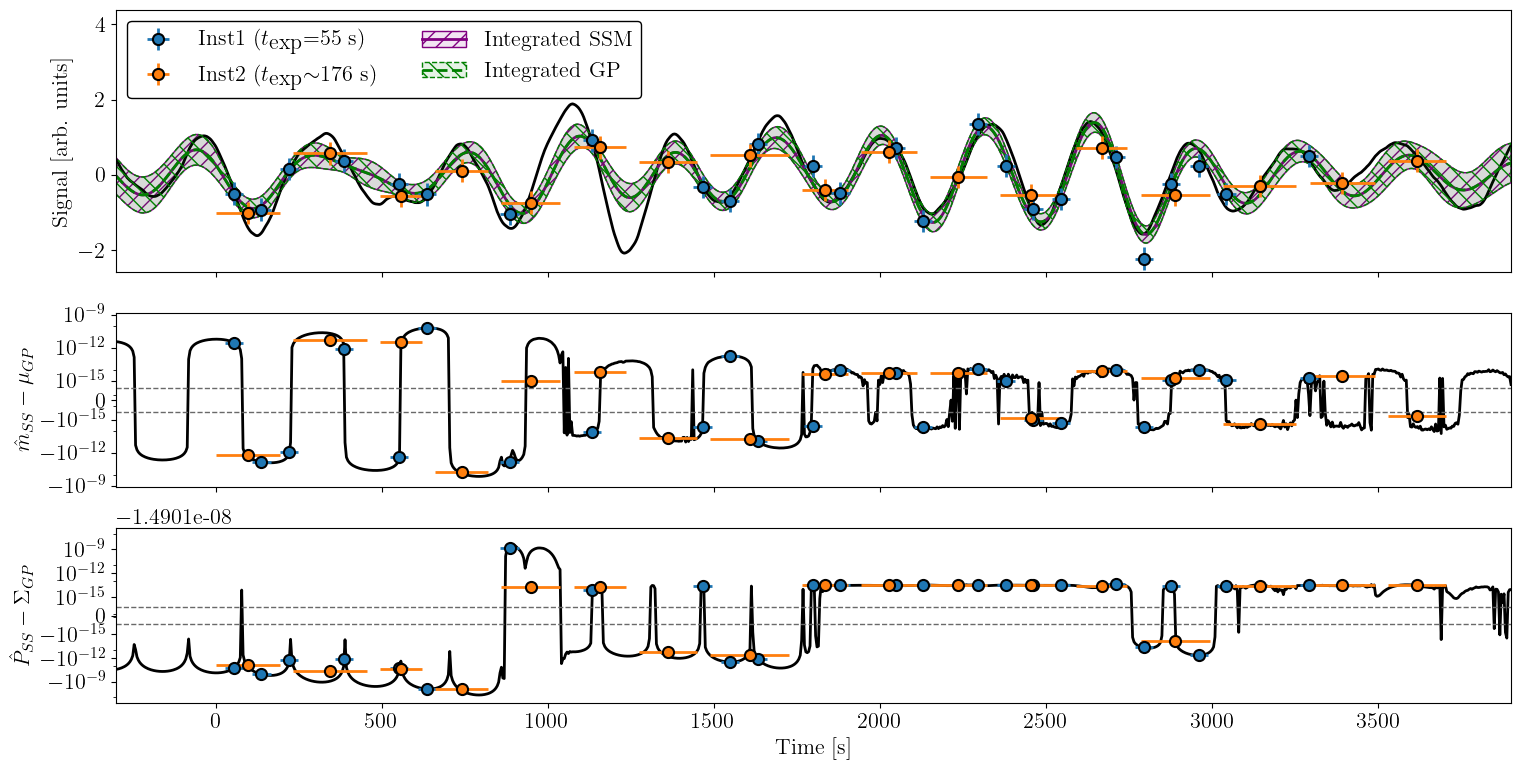

In [131]:
fig, (ax, rax, rrax) = plt.subplots(3,1, figsize=(18, 9), sharex=True, 
                                    gridspec_kw={'height_ratios':[1.5,1,1]})

cgp = 'g'
css = 'purple'
rescolor = 'k'
epscolor = 'dimgrey'
s = 7

lines = []
labels = []
l1, = ax.plot(t_true, y_true, label='True signal', ls='-', color='k', lw=2)

#### Plot the data points
for instid in range(Ninst):
    inst = (instids==instid)
    l2 = ax.errorbar(t_train[inst], y_train[inst], xerr=texp_train[inst]/2, yerr=yerr, fmt='o', zorder=100)
    if Ninst>1:
        label=f'Inst{instid+1} ($t_\\textrm{{exp}}${['=',r'$\sim$'][instid]}{np.median(texp_train[inst]):.0f} s)'
        lines.append(l2)
        labels.append(label)

### State space version
l, = ax.plot(t_test, mu_ss, color=css, ls='-', zorder=2)
h1 = ax.fill_between(t_test, mu_ss-std_ss, mu_ss+std_ss, zorder=1, color=css, alpha=0.1)
h2 = ax.fill_between(t_test, mu_ss-std_ss, mu_ss+std_ss, zorder=1, hatch="//", facecolor='none', edgecolor=css, alpha=1)
l3 = (l,h1,h2)
labels.append("Integrated SSM")

### Full GP version
l, = ax.plot(t_test, mu_gp, color=cgp,   ls='--')
h1 = ax.fill_between(t_test, mu_gp-std_gp, mu_gp+std_gp, zorder=2, ls='--', color=cgp, alpha=0.1)
h2 = ax.fill_between(t_test, mu_gp-std_gp, mu_gp+std_gp, zorder=2, ls='--', hatch="\\\\", facecolor='none', edgecolor=cgp, alpha=1)
l4 = (l,h1,h2)
labels.append("Integrated GP")

### Residual axis 1: Means
for instid in range(Ninst):
    inst = (instids==instid)
    rax.errorbar(t_train[inst], (y_ss - y_gp)[inst], xerr=texp_train[inst]/2, fmt='o', color=f'C{instid}', zorder=100)
# rax.plot(t_train, y_ss - y_gp,  'o--', color='k',  label=r'at $t$')
# for n, (t1, t2) in enumerate(zip(tstart, tend)):
#     rax.axvspan(t1, t2, color=f'C{instids[n]}', alpha=0.2)
mu_res = mu_ss - mu_gp
rax.plot(t_test, mu_res, ls='-', color=rescolor, label=r'at $t_\ast$')
rax.set(ylabel=r'$\hat{m}_{SS}- \mu_{GP}$')
eps = np.abs(np.spacing(mu_ss))
epsmax = eps.max()
rax.axhline(epsmax, color=epscolor, ls='--', lw=1)
rax.axhline(-epsmax, color=epscolor, ls='--', lw=1)
rax.set_yscale('symlog', linthresh=epsmax)
ylim = jnp.abs(mu_res).max() * 10
rax.set_ylim(-ylim, ylim)
yticks = [-1e-9, -1e-12, -1e-15, 0, 1e-15, 1e-12, 1e-9]
rax.set_yticks(yticks)

### Residual axis 2: Variances
offset = jnp.median(var_ss-var_gp); sign='$+$' if offset>=0 else '$-$'
var_res = var_ss-var_gp - offset
for instid in range(Ninst):
    inst = (instids==instid)
    rrax.errorbar(t_train[inst], (yvar_ss - yvar_gp)[inst] - offset, xerr=texp_train[inst]/2, fmt='o', color=f'C{instid}', zorder=10)
# rrax.plot(t_train, yerr_ss-yerr_gp, 'o--', color='k', label=r'at $t$')
# for n, (t1, t2) in enumerate(zip(tstart, tend)):
#     rrax.axvspan(t1, t2, color=f'C{instids[n]}', alpha=0.2)
rrax.plot(t_test, var_res,    ls='-', color=rescolor, label=r'at $t_\ast$')
rrax.set(ylabel=r'$\hat{P}_{SS}- \Sigma_{GP}$')
rrax.annotate(f'{sign}{np.abs(offset):.4e}', xy=(0, 1), xycoords='axes fraction', ha='left', va='bottom')
eps = np.abs(np.spacing(var_ss))
epsmax = eps.max()
rrax.axhline(epsmax,  color=epscolor, ls='--', lw=1)
rrax.axhline(-epsmax, color=epscolor, ls='--', lw=1)
# rrax.plot(t_test, eps, color=epscolor, ls='--', lw=1)
rrax.set_yscale('symlog', linthresh=epsmax)
ylim = jnp.abs(var_res).max() * 10
rrax.set_ylim(-ylim, ylim)

yticks = [-1e-9, -1e-12, -1e-15, 0, 1e-15, 1e-12, 1e-9]
rrax.set_yticks(yticks)

#### Formatting
lines.extend([l3, l4])
ax.legend(lines, labels, ncol=2, loc='upper left', framealpha=1, edgecolor='k', 
            # facecolor='#232323' 
            )
ax.set_ylim(f(t).min()-.5, f(t).max()+2.5)
ax.set(ylabel='Signal [arb. units]', xlim=[t_test.min(), t_test.max()]);
rrax.set(xlabel=f'Time [s]');
plt.savefig(f'/Users/rrubenzahl/Desktop/figures/ss_vs_gp_integrated_Ninst{Ninst}.png',
             dpi=300, bbox_inches='tight')

# Inspect individual state transitions 

In [75]:
# ## Inspect transition matrix between each state transition
# A = igp_ss.kernel.transition_matrix

# for k in range(1,len(t_states)):
#     dt = t_states[k]-t_states[k-1]
#     print('State', k-1, '->', k, f': {dt:.2f} sec' )
#     print(f'Obs {obsid[k-1]} {["start","end"][stateids[k-1]]} -> Obs {obsid[k]} {["start","end"][stateids[k]]}')
#     print(A(0,dt))
#     print()

In [96]:
k = 56

print('State', k, '->', k+1)
print(f'Obs {obsid[k]} {["start","end"][stateids[k]]} -> Obs {obsid[k+1]} {["start","end"][stateids[k+1]]}')
dt = t_states[k+1]-t_states[k]
print('dt =', dt)

A = igp_ss.kernel.transition_matrix
P_pred_next = P_predicted_int[k+1]
P_k = P_filtered_int[k]
A_k = A(0, dt)

A_k

State 56 -> 57
Obs 27 end -> Obs 29 start
dt = 113.0


Array([[-4.62510187e-01,  3.59962641e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.36875794e-02, -5.54505882e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.58259525e+01,  3.84618064e+03,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.46251019e+00,  3.59962641e+01,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.58259525e+01,  3.84618064e+03,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.46251019e+00,  3.59962641e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],      dtype=float64)

In [184]:
def check_P(k):
    print('Predicted Covariance eigvals>0:')
    print('  ', jnp.linalg.eigvals(P_predicted_int[k]) > 0)
    print('Filtered Covariance eigvals>0:')
    print('  ', jnp.linalg.eigvals(P_filtered_int[k]) > 0)
    print('Smoothed Covariance eigvals>0:')
    print('  ', jnp.linalg.eigvals(P_smoothed_int[k]) > 0)
    print()

# print('State 0')
# check_P(0)
for k in range(1, len(t_states)):
    if stateids[k]<2:
        print('State', k-1, '->', k)
        print(['start','end'][stateids[k-1]], '->', ['start','end'][stateids[k]])
        dt = t_states[k]-t_states[k-1] if k>0 else 0.0
        print('dt =', dt)
        check_P(k)

State 0 -> 1
start -> end
dt = 55.0
Predicted Covariance eigvals>0:
   [ True  True  True  True  True  True]
Filtered Covariance eigvals>0:
   [ True  True  True  True  True  True]
Smoothed Covariance eigvals>0:
   [ True  True  True  True  True  True]

State 1 -> 2
end -> start
dt = 27.5
Predicted Covariance eigvals>0:
   [ True  True  True  True  True  True]
Filtered Covariance eigvals>0:
   [ True  True  True  True False False]
Smoothed Covariance eigvals>0:
   [ True  True  True  True  True  True]

State 2 -> 3
start -> start
dt = 169.5
Predicted Covariance eigvals>0:
   [ True  True  True  True  True  True]
Filtered Covariance eigvals>0:
   [ True  True  True  True False False]
Smoothed Covariance eigvals>0:
   [ True  True  True  True  True  True]

State 3 -> 4
start -> end
dt = 50.5
Predicted Covariance eigvals>0:
   [ True  True  True  True  True  True]
Filtered Covariance eigvals>0:
   [ True  True  True  True  True  True]
Smoothed Covariance eigvals>0:
   [ True  True  True  

In [134]:
jnp.linalg.eigvals(P_pred_next) > 0

Array([ True,  True,  True,  True,  True,  True], dtype=bool)

In [135]:
jnp.linalg.eigvals(P_k)>0

Array([ True,  True,  True,  True, False, False], dtype=bool)

In [136]:
badthing = (P_k @ A_k.T).T
jnp.all(jnp.linalg.eigvals(badthing) > 0)

Array(False, dtype=bool)

In [ ]:
jnp.linalg.solve(P_pred_next.T, (P_k @ A_k.T).T).T

Array([[ nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  inf, -inf],
       [ nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan, -inf,  inf],
       [ nan,  nan,  nan,  nan,  nan,  nan]], dtype=float64)

In [ ]:
igp_ss.kernel.transition_matrix(0, 0)

Array([[ 1.,  0.,  0.,  0.,  0.,  0.],
       [-0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [-0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [-0.,  0.,  0.,  0.,  0.,  1.]], dtype=float64)

In [ ]:
igp_ss.kernel.integrated_transition_matrix(0, 0)

Array([[ 0.,  0.],
       [-0.,  0.]], dtype=float64)

# TODO: test predict with arbitrary exposure time